# Survial Models

## Time to event data

Often, we are interested in determining how some variable or intervention affects the time to occurence of a certain outcome. For example, a researcher may be interested in how a particular drug affects how long a person will survive with a particular disease. Here we want to examine the waiting time for the occurence of such events. 

In survival analysis, the likelihood is somewhat more involved in its formulation. To be able to properly discuss the likelihood specification in survival models, however, we must first discuss several key quantities in survival analysis. As discussed, our main outcome of interest is time, which has support $0\leq t< \infty$. We denote our time as with a random variable $T$.


## Important quantities in Survival Analysis

If the random variable $T$ is the time to the event we are studying, we can make probability statements about the lifetime of individuals. For example, we can calculate the probability of surviving past a particular time $t$ (i.e. $P(T>t)$). This probability, known as the survival function is the primary object of interest in survival analysis. The survival function is denoted by

$$S(t) = P(T > t) = 1 - F(t),$$

where $F$ is the [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of $T$.  It is mathematically convenient to express the survival function in terms of the [hazard rate](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function), $h(t)$.  The hazard rate is the instantaneous probability that the event occurs at time $t$ given that it has not yet occured.  That is,

$$\begin{align*}
h(t)
    & = \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t\ |\ T > t)}{\Delta t} \\
    & = \frac{f(t)}{S(t)}
\end{align*}$$

Furthermore, we have that

$$S(t) = \exp\left(-\int_0^t h(s)\ ds\right).$$

This representation of the survival function shows that the cumulative hazard function

$$H(t) = \int_0^t h(s)\ ds$$

is an important quantity in survival analysis, since we may consicesly write $S(t) = \exp(-H(t)).$

An important, but subtle, point in survival analysis is [censoring](https://en.wikipedia.org/wiki/Survival_analysis#Censoring). In many survival studies, many data points are `right censored` or rather survival times are usually only known for a portion for those under study where as the remainder are only known to exceed certain values. Specifically, an observation is said to be right censored at $c$ if the exact value of the observation is not known but only that it is greater than or equal to $c$. 

### Data notation

Suppose that there are $n$ subjects under study and that associated with the $i^{th}$ individual is a survival time $t_i*$ and a fixed censoring time $c_i$. The exact survival time $t_i$ will be observed only if $t_i* \leq c_i$. Hence our data is of the form $(y_i,\delta_i)$ where
$$
\begin{equation}
t_i = min(t_i*, c_i)
\end{equation}
$$
and 
$$
\begin{equation}
\delta_i= I(t_i*\leq c_i)
\end{equation}
$$

In our dataset, $\delta_i$ is given by `df.event` and 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from pymc3 import Gamma, Poisson, Normal, Model, sample, forestplot, NUTS, Metropolis, find_MAP, starting, traceplot
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels import datasets
from theano import tensor as tt
from io import StringIO
import warnings
warnings.simplefilter('ignore')

sns.set_style("ticks")

SEEDS = 2234323, 172354266
np.random.seed(SEEDS)

In [2]:
blue, _, red = sns.color_palette()[:3]

### Mastectomy Data

In this tutorial, we will use an oncological dataset.
In this dataset, each row represents observations from a woman diagnosed with breast cancer that underwent a mastectomy. The column `time` ($t_i$) represents the time (in months) post-surgery that the woman was observed. The column `event` indicates whether or not the woman died during the observation period (i.e. $\delta_i$). The column `metastized` represents whether the cancer had metastized prior to surgery.

We will analyze the relationship between survival time post-mastectomy and whether or not the cancer had metastized.

In [3]:
df = datasets.get_rdataset('mastectomy', 'HSAUR', cache=True).data
df.event = df.event.astype(np.int64)
df.metastized = (df.metastized == 'yes').astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

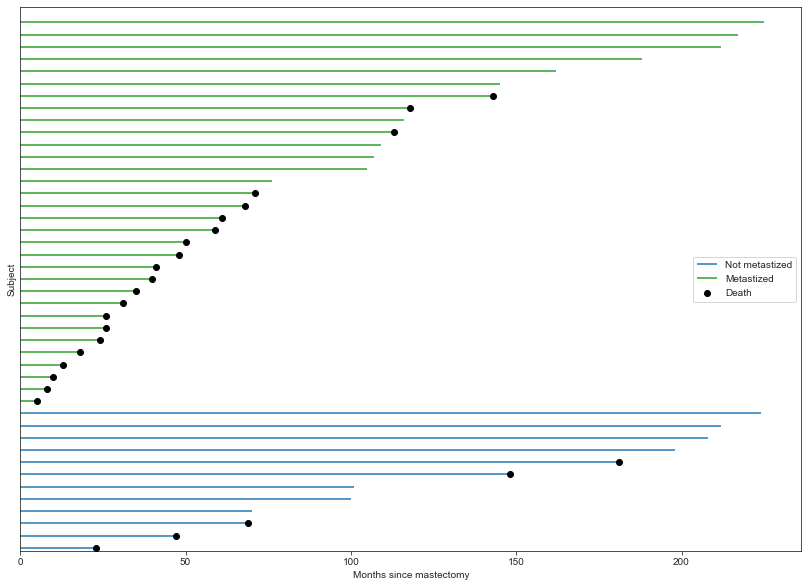

In [4]:
fig, ax = plt.subplots(figsize=(14, 10))

blue, _, green = sns.color_palette()[:3]

ax.hlines(patients[df.metastized.values == 0], 0, df[df.metastized.values == 0].time,
          color=blue, label='Not metastized')

ax.hlines(patients[df.metastized.values == 1], 0, df[df.metastized.values == 1].time,
          color=green, label='Metastized')

ax.scatter(df[df.event.values == 1].time, patients[df.event.values == 1],
           color='k', zorder=10, label='Death')

ax.set_xlim(left=0)
ax.set_xlabel('Months since mastectomy')
ax.set_yticks([])
ax.set_ylabel('Subject')

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='center right');

As an initial look into survival, we plot the non-parametric Kaplan Meier estimates of the survival via the package `lifelines`

In [6]:
!conda install -y lifelines

Solving environment: done

## Package Plan ##

  environment location: /Users/twiecki/miniconda3

  added / updated specs:
    - lifelines


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libopenblas-0.3.10         |openmp_h63d9170_4         8.2 MB  conda-forge
    llvm-openmp-10.0.1         |       h28b9765_0         265 KB  conda-forge
    matplotlib-base-3.1.3      |   py37h11da6c2_0         6.6 MB  conda-forge
    numpy-1.19.1               |   py37h7e69742_0         5.1 MB  conda-forge
    scipy-1.3.3                |   py37h82752d6_0        18.3 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        38.5 MB

The following NEW packages will be INSTALLED:

  autograd           conda-forge/noarch::autograd-1.3-py_0
  autograd-gamma     conda-forge/noarch::autograd-gamma-0.4.1-py_0
  cycler             

In [7]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [8]:
kmf.fit(df.time, event_observed=df.event)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 44 total observations, 18 right-censored observations>

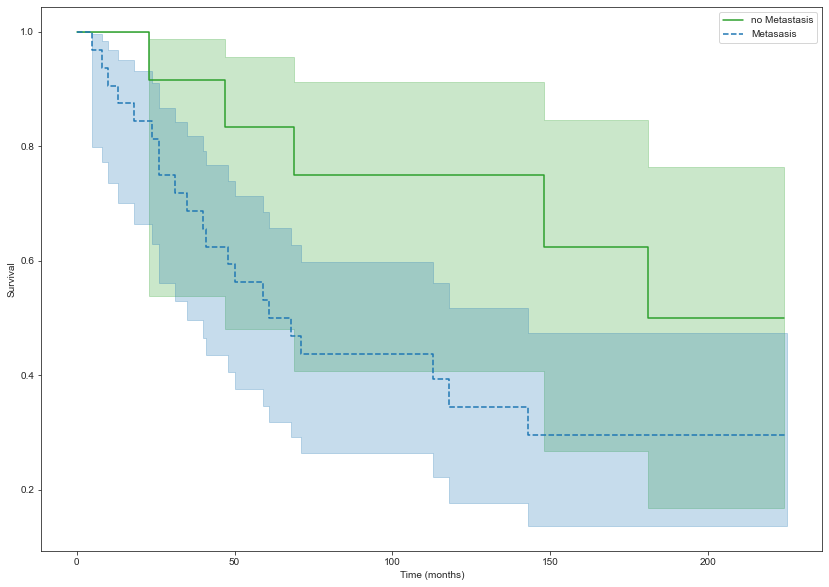

In [9]:
time = df.time
event = df.event
ix0 = df.metastized==0
ix1 = df.metastized==1

kmf.fit(time[ix0], event[ix0], label='no Metastasis')
ax = kmf.plot(color=green)

kmf.fit(time[ix1], event[ix1], label='Metasasis')
kmf.plot(ax=ax, ls='dashed', color=blue, figsize=(14,10))
ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival');

# Model Specification

We wish to relate a treatment effect in some way to the time to event outcome. There are several ways to do this, but two main paradigms are pervasive in the literature:

1. Proportional Hazards 
2. Accelerated Failure Time

In this lecture we will focus on the first of these models. 

There are a number of probability models one could use for lifetime data but the Weibull distribution is a very flexible model that is popular with many researchers. Its flexibility comes from the fact that it has a hazard rate which is either monotone increasing, decreasing, or constant. Additionally, it is the only parametric regression model which has both a proportional hazards representation and an accelerated failure-time representation. Again, however, we will only be focusing on the Proportional hazards specification. 


## Proportional Hazards Model

The main objective at this point is to specify a model that relates the group effect to the time outcome. Recall above that the hazard quantifies the instantaneous risk of disease at a given time point. 

It turns out that the easiest survival parameter to model is the hazard rate: which tells us how quickly individuals of a certain age are experiencing the event of interest. The major approach to modeling the effects of covariates on survival is to model the conditional hazard rate as a function of the covariates. Two general classes of models have been used to relate covariate effects to survival:

1. the family of multiplicative hazard models, and 
2. the family of additive hazard rate models.

We will focus on the former of these here. 

For the family of multiplicative hazard rate models the conditional hazard rate of an individual with covariate vector $X$ as a product of a baseline hazard rate $h_0(t)$ and a non-negative function of the covariates,
$c(\beta^T X)$, that is, $h (t | z) =h_0(t)c(\beta^T X)$.
   
   -$h_0(x)$ may have a specified parametric form or it may be left as an arbitrary non-negative function.
    
   - Any non-negative function can be used for the link function $c()$. Most applications use the Cox (1972) model with $c(\beta^T X) = \exp(\beta^T X)$ which is chosen for its simplicity
   - Key Feature: when all the covariates are fixed at time 0, the hazard rates of two individuals with distinct
   values of X are proportional. 
   

Using the exponential link, we have
$$
{\displaystyle h (t|X_{i})=h _{0}(t)\exp(\beta^T X_{i} )}
$$

That is to say, the model is formulated in such a fashion that the group effect has a multiplicative effect on the hazard. Typically, semi-parametric models which don't have explicit representations of $h_0(t)$ are preferred. However, for the purposes of this tutorial, we will assume a particular form for this baseline hazard.

The Weibull proportional hazards model models the hazard as 

$$
{\displaystyle h (t|X_{i})=\alpha\lambda t^{\alpha-1}\exp(\beta^TX_{i})}
$$


## Likelihood Specification

Due to right censoring, we need to adjust our likelihood to account for observations where we know that an individual survived up to a particular point. If a person is known to have survived at least to time $t$, then their likelihood contribution is simply the survival function evaluated at the censoring time. We typically express this with an indicator variable $(\delta_i)$ for each observation denoting whether or not the individual was right censored or observed.

First, recall that the Weibull proportional hazards model models the hazard as a function of the covariates. The probability density function is related to the hazard by:

$$
\begin{equation}
f(t) = h(t)S(t)
\end{equation}
$$


The likelihood specification for an individual is therefore given by:
$$
\begin{eqnarray}
L_i &=& [f(t|X)]^{\delta_i}[S(t|X)]^{1-\delta_i}\\
&=& [h(t|X)S(t|X)]^{\delta_i}[S(t|X)]^{1-\delta_i}\\
&=& [\alpha\lambda t^{\alpha-1}\exp(\beta^T X)exp(-\lambda t^{\alpha}\exp(\beta^T X))]^{\delta_i}[exp(-\lambda t^{\alpha}\exp(\beta^T X))]^{1-\delta_i}\\
&=&[\alpha\lambda t^{\alpha-1}\exp(\beta^T X-\lambda t^{\alpha}\exp(\beta^T X))]^{\delta_i}[exp(-\lambda t^{\alpha}\exp(\beta^T X))]^{1-\delta_i}\\
\end{eqnarray}
$$



### Specification in PyMC3

We've formulated the mathematical form of our likelihood - we now need to implement it. PyMC3 makes this really easy to do with the `DensityDist` class. All that is needed to specify a likelihood is a python function that passes the log of the likelihood.

Continuing from before:

$$
\begin{eqnarray}
log L_i &=& \log[[\alpha\lambda t^{\alpha-1}\exp(\beta^T X-\lambda t^{\alpha}\exp(\beta^T X))]^{\delta_i}[exp(-\lambda t^{\alpha}\exp(\beta^T X))]^{1-\delta_i}]\\
&=& \delta_i \log[\alpha\lambda t^{\alpha-1}\exp(\beta^T X-\lambda t^{\alpha}\exp(\beta^T X))]+(1-\delta_i)(-\lambda t^{\alpha}\exp(\beta^T X))\\
&=&\delta_i(\log\alpha+\log\lambda+(\alpha-1)\log t + \beta^T X) - \lambda t^{\alpha}\exp(\beta^T X)
\end{eqnarray}
$$


In [13]:
## program log likelihood

def logp(event):
    return (event*(tt.log(α) + tt.log(λ) 
                   + tt.log(tt.exp(β*np.array(metast)))
                   + (α-1)*tt.log(np.array(time))) 
            - (λ*tt.exp(β*np.array(metast)) 
                   * np.array(time)**α))
    
    survival = pm.DensityDist('survival', logp, 
                              observed={'event': event})

### Prior Distribution specification:
Recall that in a Bayesian framework, estimated parameters are considered random variables - so we need to place a prior distribution on them. Looking at the parameters to estimate, we have 

1. Weibull baseline hazard parameters: $\alpha$,$\lambda>0$
    - A natural prior for these parameters would be the Gamma distribution.

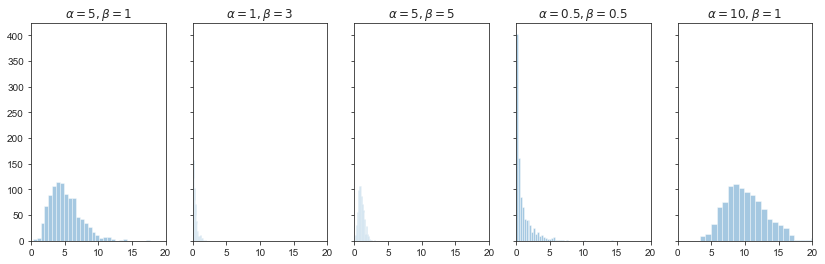

In [14]:
from pymc3 import Gamma

params = (5, 1), (1, 3), (5, 5), (0.5, 0.5), (10, 1)

fig, axes = plt.subplots(1, len(params), figsize=(14, 4), sharey=True)
for ax, (alpha, beta) in zip(axes, params):
    sns.distplot(Gamma.dist(alpha, beta).random(size=1000), ax=ax, kde=False)
    ax.set_xlim(0, 20)
    ax.set_title(r'$\alpha={0}, \beta={1}$'.format(alpha, beta));

 - Alternatively, one might specify a Half Cauchy distribution:

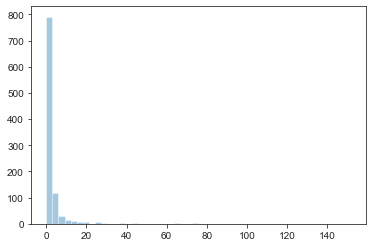

In [15]:
sns.distplot(pm.HalfCauchy.dist(1).random(size=1000), kde=False)

2. Group effect: $-\infty<\beta<\infty$

For the effect of metastasis, the most natural prior is the Normal distribution.

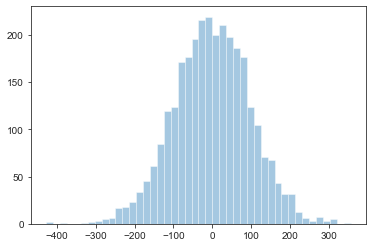

In [16]:
sns.distplot(pm.Normal.dist(0,100).random(size=3000), kde=False)

### Implementation in PyMC3

Putting all the pieces together, we can fit the model using the `pymc` framework as so:

In [17]:
metast = df.metastized.values

In [18]:
n_iterations = 2000
n_tune = 1000

In [36]:
with Model() as weibull_model:
    α = pm.HalfCauchy("α", 1)
    # Weibull shape parameter
    λ = pm.HalfCauchy("λ", 1)
    # Effects of metastisis
    β = pm.Normal('β', 0, 100)
    # Weibull scales
    linear = pm.Deterministic('linear', tt.exp(β*metast))

    # Weibull survival likelihood, accounting for censoring
    def logp(event):
        return event*(tt.log(α) + tt.log(λ) + tt.log(linear) 
                      + (α-1)*tt.log(np.array(time))) - (λ*linear * np.array(time)**α)
    
    survival = pm.DensityDist('survival', logp, 
                              observed={'event': event})
    weibull_trace = pm.sample(n_iterations, tune=n_tune, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, λ, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.887443419244335, but should be close to 0.8. Try to increase the number of tuning steps.


We can view the posterior samples and assess convergence of the Markov Chain:

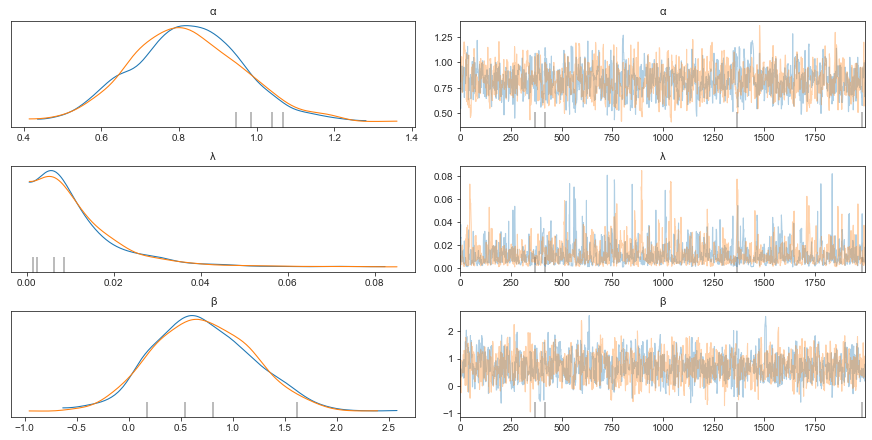

In [20]:
az.plot_trace(weibull_trace, var_names=['α', 'λ', 'β']);

Since we have fit a proportional hazards model, the interpretation of the group effect is straightforward (at least with respect to the hazard). We need only to exponentiate the $\beta$ posterior samples for the effect size and corresponding credible intervals.

In [21]:
hr_samps = np.exp(weibull_trace['β'])
print('Hazard ratio (metastisized vs not metastisized) at 5 years: {0:.2f} {1}'.format(hr_samps.mean(), 
                                                            np.percentile(hr_samps, [2.5, 97.5]).round(2)))

Hazard ratio (metastisized vs not metastisized) at 5 years: 2.28 [0.84 5.23]


> Interpretation: This means that the hazard for the group with metastasis is bigger
than the one for the group with no metastasis. This indicates metastasis has a negative effect on survival. 

### Posterior Survival quantites

Given that we have posterior samples for each of the parameters, it is straightforward to obtain posterior survival curves, hazard rates, etc, with corresponding credible intervals. 

In [22]:
## Plot survival curves
n_intervals = 120
interval_bounds = np.arange(0, n_intervals + 1, 1)

In [23]:
#baseline_lam = np.exp(weibull_trace['β'][n_burn:,0])
baseline_lam = np.repeat(1., n_iterations*2)
metast_lam = np.exp(weibull_trace['β'])
λ_trace = weibull_trace['λ']
α_trace = weibull_trace['α']

In [24]:
def plot_with_hpd(x, lam, f, ax, linestyle='-', color=None, label=None, alpha=0.05, debug=False, **kwargs):

    m = np.median(f(lam, **kwargs), axis=0)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(lam, **kwargs), percentiles, axis=0)
    
    if debug:
        import pdb;pdb.set_trace()
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.15)
    ax.step(x, m, color=color, linestyle=linestyle, label=label);

In [25]:
def cum_weibull_hazard(lam, α=α_trace ,λ=λ_trace, t=n_intervals):
    return (λ_trace.reshape(-1,1)*lam.reshape(-1,1) * np.arange(t)) ** α.reshape(-1,1)

def weibull_survival(lam,α=α_trace, λ=λ_trace, t=n_intervals):
    return np.exp(-cum_weibull_hazard(lam, α, λ, t))

def cum_hazard(hazard, n=n_intervals):
    return (np.arange(n) * hazard.reshape(-1,1)).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

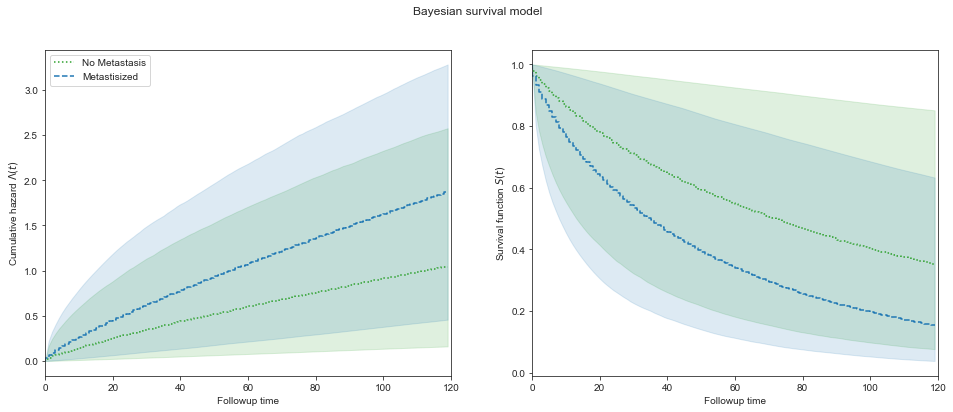

In [26]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_lam, cum_weibull_hazard,
              hazard_ax, color=green, linestyle=':', label='No Metastasis')
plot_with_hpd(interval_bounds[:-1], metast_lam, cum_weibull_hazard,
              hazard_ax, color=blue, linestyle='--', label='Metastisized')

hazard_ax.set_xlim(0, n_intervals);
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_lam, weibull_survival,
              surv_ax, color=green, linestyle=':')
plot_with_hpd(interval_bounds[:-1], metast_lam, weibull_survival,
              surv_ax, color=blue, linestyle='--')


surv_ax.set_xlim(0, n_intervals);
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

Looking at our KM estimate from earlier, we see that the posterior survival curves follow closely to the non-parametric K-M estimates. 

In [27]:
## Hazard ratio comparing 2 groups at a given time point 
def weibull_hazard(lam, t, α=α_trace, λ=λ_trace):
    return (α.reshape(-1,1) * λ.reshape(-1,1) * lam.reshape(-1,1) * t**(α.reshape(-1,1) - 1))

We can of course, obtain our hazard ratio from the posterior samples:

In [28]:
hazard_ratio = weibull_hazard(metast_lam, 60)/weibull_hazard(baseline_lam, 60)
print('Hazard ratio (metastisized vs notmetastisized) at 5 years: {0} {1}'.format(hazard_ratio.mean(),                                                     np.percentile(hazard_ratio, [2.5, 97.5])))

Hazard ratio (metastisized vs notmetastisized) at 5 years: 2.2798788499285894 [0.83868425 5.23182762]


In [29]:
### Other quantities of interest:

baseline_survival = weibull_survival(baseline_lam)
metast_survival = weibull_survival(metast_lam)

In [30]:
#Time where surivial is .5
np.where(baseline_survival.mean(axis=0)<=0.5)[0][0]
np.where(metast_survival.mean(axis=0)<=0.5)[0][0]

38

In [31]:
baseline_survival_5 = baseline_survival[:, 60]
metast_survival_5 = metast_survival[:, 60]
print('Baseline 5-year median survival: {0:.2f} {1}'.format(np.median(baseline_survival), 
                                                        np.percentile(baseline_survival, [2.5, 97.5]).round(2)))

print('Metastasis group median 5-year survival: {0:.2f} {1}'.format(np.median(metast_survival_5), 
                                                        np.percentile(metast_survival_5, [2.5, 97.5]).round(2)))

Baseline 5-year median survival: 0.60 [0.14 0.98]
Metastasis group median 5-year survival: 0.34 [0.11 0.81]


## Exercise: Heart transplant survival

Try your hand at building a survival model using PyMC3. Here is a small dataset based on 69 patients receiving heart transplants. Taken from "The Statistical Analysis of Failure Time Data" by Kalbfleisch and Prentice, Appendix I, pages 230-232 from stalib data depository. http://lib.stat.cmu.edu/datasets/stanford 
  
Data columns:
- Age at transplant in years 
- Survival Status 1=dead 0=alive 
- Survival Time after transplant in days 

Estimate the relationship between age at transplant and survival probability.

In [32]:
data_str = """
41 1 5 
40 1 16 
54 1 16 
29 1 17 
55 1 28 
52 1 30 
40 1 39 
35 0 39 
56 1 43 
36 1 45 
42 1 51 
50 1 53 
42 1 58 
52 1 61 
61 1 66 
45 1 68 
49 1 68 
53 1 72 
47 1 72 
64 1 77 
51 1 78 
53 1 80 
54 1 81 
56 1 90 
53 1 96 
48 1 100 
28 0 109 
46 1 110 
23 0 131 
47 1 153 
43 1 165 
26 0 180 
52 1 186 
47 1 188 
51 1 207 
51 1 219 
47 0 265 
48 1 285 
19 1 285 
49 1 308 
42 1 334 
44 0 340 
47 1 342 
54 0 370 
48 0 397 
52 0 445 
46 0 482 
48 0 515 
52 0 545 
48 1 583 
26 0 596 
47 0 630 
47 0 670 
50 1 675 
58 1 733 
32 0 841 
44 1 852 
41 0 915 
38 0 941 
45 1 979 
48 1 995 
43 1 1032 
36 0 1141 
45 0 1321 
53 1 1386 
48 0 1407 
40 0 1571 
48 0 1586 
33 0 1799 
"""

transplant_data = pd.read_table(StringIO(data_str), sep='\s+', names=['transplant_age', 'death', 'time'])
transplant_data.head()

,transplant_age,death,time
0,41,1,5
1,40,1,16
2,54,1,16
3,29,1,17
4,55,1,28


---
# References 

Ibrahim, Joseph G., Ming‐Hui Chen, and Debajyoti Sinha. Bayesian survival analysis. John Wiley & Sons, Ltd, 2005.

Klein, John P., Moeschberger, Melvin L. Survival Analysis: Techniques for Censored and Truncated Data Second Edition. Springer, 2003.
